In [ ]:
!pip install pyvirtualdisplay
!apt-get install xvfb
!apt-get install -y swig
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
import gym
import PIL.Image
from pyvirtualdisplay import Display
import time
import numpy as np
import random
from collections import deque, namedtuple

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
Display(visible=0, size=(840, 480)).start()

In [ ]:
env = gym.make('LunarLander-v2')

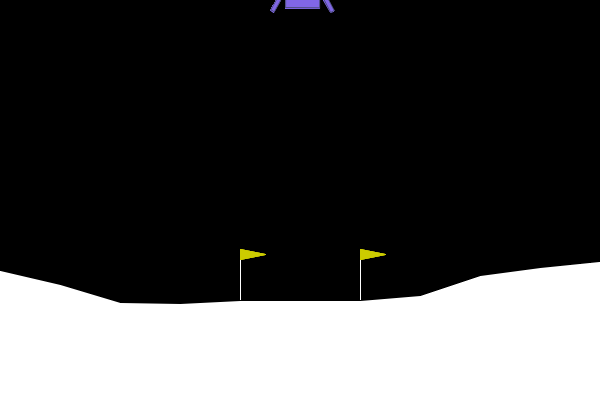

In [ ]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
print(f"Total Number of Observations : {env.observation_space.shape}")
print(f"Total Number of Actions : {env.action_space.n}")

Total Number of Observations : (8,)
Total Number of Actions : 4


In [ ]:
current_state = env.reset()

[ 1.3483048e-03  1.4108433e+00  1.3654630e-01 -3.4132111e-03
 -1.5554980e-03 -3.0929765e-02  0.0000000e+00  0.0000000e+00]
[ 2.6519776e-03  1.4108417e+00  1.3214144e-01 -7.2689807e-05
 -3.3006598e-03 -3.4905922e-02  0.0000000e+00  0.0000000e+00]
-0.02979368792863396
False


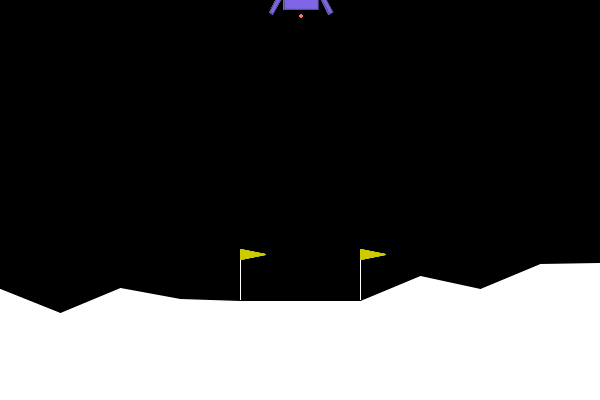

In [ ]:
action = 2

next_state, reward, done, _ = env.step(action)

print(current_state)
print(next_state)
print(reward)
print(done)

current_state = next_state

PIL.Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
import tensorflow as tf
tf.random.set_seed(0)     #############

In [ ]:
num_observations = env.observation_space.shape

In [ ]:
DQN = Sequential([
    Input(shape=num_observations),
    Dense(units=64,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=4,activation='linear')
])

target_DQN = Sequential([
    Input(shape=num_observations),
    Dense(units=64,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=4,activation='linear')
])

In [ ]:
def calculate_loss(experiences, gamma, DQN, target_DQN):

  current_states, actions, rewards, next_states, done_values = experiences

  max_Q_values = tf.reduce_max(target_DQN(next_states), axis=-1)
  Y_target = rewards + (gamma*max_Q_values*(1-done_values))

  q_values = DQN(current_states)
  Q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),tf.cast(actions,tf.int32)],axis=1))

  loss = MSE(Y_target, Q_values)

  return loss

In [ ]:
alpha = 1e-3
optimizer = Adam(learning_rate = alpha)

In [ ]:
# SOFT UPDATE
def update_target_network(DQN, target_DQN):
    for dqn_weights, target_dqn_weights in zip(DQN.weights, target_DQN.weights):
      target_dqn_weights.assign(alpha*dqn_weights + (1.0-alpha)*target_dqn_weights)

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
  with tf.GradientTape() as tape:
    loss = calculate_loss(experiences, gamma, DQN, target_DQN)

  gradients = tape.gradient(loss, DQN.trainable_variables)

  optimizer.apply_gradients(zip(gradients,DQN.trainable_variables))

  update_target_network(DQN,target_DQN)

In [ ]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
MINIBATCH_SIZE = 64
def get_experiences(memory_buffer):

  experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
  states = tf.convert_to_tensor(
      np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
  )
  actions = tf.convert_to_tensor(
      np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
  )
  rewards = tf.convert_to_tensor(
      np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
  )
  next_states = tf.convert_to_tensor(
      np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
  )
  done_vals = tf.convert_to_tensor(
      np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
      dtype=tf.float32,
  )
  return (states, actions, rewards, next_states, done_vals)

In [ ]:
start = time.time()

episodes_num = 2000
max_steps_num = 1000

MEMORY_SIZE = 100_000
memory_buffer = deque(maxlen = MEMORY_SIZE)

point_history = []

epsilon = 1.0
gamma = 0.995
E_DECAY = 0.995
E_MIN = 0.01
SIZE_TO_AVG = 100

target_DQN.set_weights(DQN.get_weights())

for i in range(episodes_num):
  state = env.reset()
  total_reward_points = 0

  for j in range(max_steps_num):
    qn_state = np.expand_dims(state,axis=0)
    q_values = DQN(qn_state)

    action = np.argmax(q_values.numpy()[0]) if (random.random() > epsilon) else random.choice(np.arange(4))

    next_state, reward, done, _ = env.step(action)

    memory_buffer.append(experience(state, action, reward, next_state, done))

    update = True if ((j+1)%4 ==0 and len(memory_buffer) > 64) else False

    if update:
      experiences = get_experiences(memory_buffer)
      agent_learn(experiences, gamma)

    state = next_state.copy()
    total_reward_points += reward

    if done:
      break
  point_history.append(total_reward_points)
  avg_points = np.mean(point_history[-SIZE_TO_AVG:])

  epsilon = max(E_MIN, E_DECAY * epsilon)

  print(f"\rEpisode {i+1} | Total point average of the last {SIZE_TO_AVG} episodes: {avg_points:.2f}", end="")

  if (i+1) % 100 == 0:
    print(f"\rEpisode {i+1} | Total point average of the last {SIZE_TO_AVG} episodes: {avg_points:.2f}")

  if avg_points > 200:
    print(f"\n\nEnvironment solved in {i+1} episodes!")
    DQN.save('lunar_lander_model.h5')
    break


stop = time.time()
print(f"Total Time require To Train a Model : {(stop-start)/60:.2f} min")

Episode 100 | Total point average of the last 100 episodes: -163.79
Episode 200 | Total point average of the last 100 episodes: -101.07
Episode 300 | Total point average of the last 100 episodes: -65.54
Episode 400 | Total point average of the last 100 episodes: 29.56
Episode 500 | Total point average of the last 100 episodes: 151.07
Episode 600 | Total point average of the last 100 episodes: 177.82
Episode 650 | Total point average of the last 100 episodes: 199.08

Episode 651 | Total point average of the last 100 episodes: 201.20

Environment solved in 651 episodes!
Total Time require To Train a Model : 30.67 min


In [ ]:
import imageio
import IPython
import base64

def embed_mp4(filename):
    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)


def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)

In [ ]:
filename = "lunar_lander.mp4"

create_video(filename, env, DQN)
embed_mp4(filename)